# Harmonic Regression on LandSat 8 Time Series
Harmonic regression has been found to be a powerful tool for modeling attributes and
health of vegetation and forest inventory. Traditionally this is a difficult computational problem because of the huge time series of data required for the analysis. This demo shows how this can be done quickly and easily using the Geodesic platform.



## Tasseled Cap Transformation
Multispectral analysis of vegetation and forest land often use some sort of index 
or transformation to extract or compress the information in the data. The Tasseled Cap
transformation is a linear combination of the bands of the Landsat 8 satellite that
has been found to be useful for this purpose. This process is similar to a principal
components analysis, but is more specific to the Landsat 8 data. The transformation
takes in six bands of the Landsat 8 data and outputs three bands that are useful for
vegetation analysis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def tasseled_cap(data: np.ndarray) -> np.ndarray:
    """Tasseled Cap Transformation (TCT) is a linear transformation of Landsat 8 bands.

    Coefficients obtained from the paper: https://www.tandfonline.com/doi/full/10.1080/2150704X.2014.915434
    Can also be found at: https://yceo.yale.edu/tasseled-cap-transform-landsat-8-oli
    """
    tc_xform = np.array(
        [  # blue, green, red, NIR, SWIR1, SWIR2
            [0.3029, 0.2786, 0.4733, 0.5599, 0.508, 0.1872],  # Brightness
            [-0.2941, -0.243, -0.5424, 0.7276, 0.0713, -0.1608],  # Greenness
            [0.1511, 0.1973, 0.3283, 0.3407, -0.7117, -0.4559]  # Wetness
        ]
    )
    return np.einsum('ij,ljno->lino', tc_xform, data)

## Harmonic Regression
We would like to use the Tasseled Cap transformation to analyze the health of vegetation through time and identify any trends. This can be done using a harmonic regression. A harmonic regression is a linear regression that uses sine and cosine functions as the basis functions. This allows us to model periodic behavior in the data. In this case, we will use a harmonic regression to model the seasonal behavior of the vegetation. 

To perform the regression we will use a least squares fit. This is a common method for fitting a and most importantly because the is a geospatial problem in addition to a 
temporal problem can be vectorized and solved quickly. We will be able to fit all pixels in the array at once. We will use the numpy.linalg.lstsq function to perform the regression. This function takes in a matrix of basis functions and a vector of observations and returns the coefficients of the regression. More specifically it solves for the coefficients $x$ in the equation $Ax = b$ where $A$ is the matrix of basis functions and $b$ is the vector of observations.

To start with lets definte the matrix of basis functions. Because this is a harmonic
regression this will be an n-th order fourier series.
$$ A_{i} = 1 + t_i + \sum\limits_{k=1}^{n} \sin(\frac{2\pi k t_i}{P}) +  \sum\limits_{k=1}^{n} \cos(\frac{2\pi k t_i}{P})  $$

In [3]:
# Produces a matrix that can be used as the A matrix in a least squares problem
def fourier_matrix(times, order=4, P=365.2421891):
    nt = len(times) # number of time steps
    A = np.ones((nt, (2*order+2))) # A[0] = 1 for the constant term
    A[:, 1] = times # linear term
    n = 1
    for i in range(2, (2*order)+2, 2):
        A[:, i] = np.sin(2*n*np.pi*times/P)
        A[:, i+1] = np.cos(2*n*np.pi*times/P)
        n += 1
    return A

## Least Squares Fit Function
Now we can write a function that can take in a matrix of observations and a matrix of times to construct the matrices $A$ and $b$ and solve for the coefficients $x$.

In [4]:
def lstsq(times, data, order=4):
    """Least squares fit of a fourier series to a target using scipy.linalg.lstsq
    
    Args:
        times (np.ndarray): 1D array of times
        data (np.ndarray): 4D array of data to fit. Axes are (time, band, y, x)
        order (int, optional): Order of the fourier series. Defaults to 4.
    """
    A = fourier_matrix(times, order=order)
    t, b, y, x = data.shape
    data = np.moveaxis(data, 0, -1)
    data = data.reshape(y*x*b, t)
    params, res, rank, s = np.linalg.lstsq(A, data.T, rcond=None)
    return params.reshape(2*order+2, b, y, x)


## Testing the Function
To test the function we will construct a simple sine wave that has a linear component and some random noise. We will then use the function to fit the data and plot the results.

In [5]:
P = 365.2421891 # Period of the signal. 1 siderial year in days
times = np.arange(0,1000, 1, dtype=np.float64)

base_vals = np.sin((2*np.pi/P)*times)+2
lin = 0.002*times
noise = np.random.normal(scale=0.1, size=(len(times)))

# sum the 3 components of the signal
noisey_vals = base_vals + noise + lin

# make a 4D array of the signal. This just duplicates the same signal 3 times for
# the 3 TCT bands, then 128x128 for the image size.
data = np.tile(noisey_vals, (3,128,128,1))
data = np.moveaxis(data, -1, 0)
data.shape # (time, band, y, x)

(1000, 3, 128, 128)

### Run the Least Squares Fit

In [6]:
x = lstsq(times, data, order=4)
x.shape # (number of params, TCT bands, y, x)

(10, 3, 128, 128)

### Plot the Results
First we will write a little helper function that can take the parameters from the 
regression and construct the fitted curve. The plot the fit and the original noisey sine wave.

In [7]:
def fourier_series(x, t, order=4) -> np.float64:
    P = 365.2421891  # siderial days per year. Same as used in https://www.sciencedirect.com/science/article/abs/pii/S0924271618300066?via%3Dihub
    y = x[0] + x[1]*t
    n = 1
    for i in range(2, (2*order)+2, 2):
        y = y + x[i]*np.sin(2*n*np.pi*t/P) + x[i+1]*np.cos(2*n*np.pi*t/P)
        n += 1
    return y


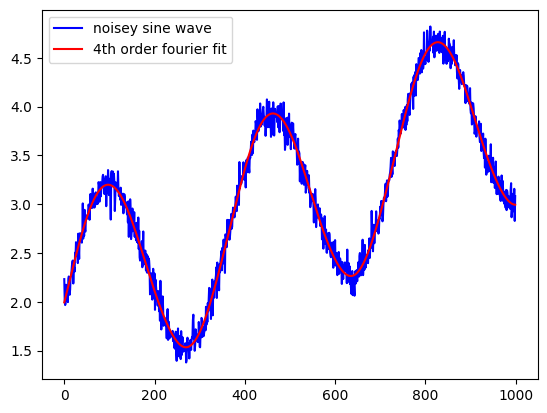

In [8]:
fit = fourier_series(x[:,0,0,0], times, order=4) # just take one of the pixel/bands from the fit
plt.plot(data[:, 0, 0, 0], color='blue', label='noisey sine wave')
plt.plot(fit, color='red', label='4th order fourier fit')
plt.legend()
plt.show()

As we can see the fit is very good. The linear component is captured well and despite being a noisy signal we can still see that the sine component is extracted well.

## Least Squares with Missing Data

Unfortunately we cant use the above method exactly as is. The Landsat 8 data has some missing data. This is because the satellite does not always collect data for every pixel in every band. This is due to clouds or other atmospheric conditions. We will need to modify the least squares fit to account for this. We can use a method outlined in [Solving Least Squares Regression with Missing Data](https://alexhwilliams.info/itsneuronalblog/2018/02/26/censored-lstsq/). 

In [9]:
def censored_lstsq(A, B, M):
    """Solves least squares problem subject to missing data.

    Code taken from blog: https://alexhwilliams.info/itsneuronalblog/2018/02/26/censored-lstsq/
    If you are masking out np.nan values, you will need to set them to another number. These
    indices will be ignored because they are multiplied by 0, but if they are left as NaNs,
    the whole fit on that row will be NaN.

    Args:
        A (np.ndarray) : m x r matrix
        B (np.ndarray) : m x n matrix
        M (np.ndarray) : m x n binary masking matrix (zeros indicate missing values)

    Returns:
        X (ndarray) : r x n matrix that minimizes norm(M*(AX - B))
    """
    if B.ndim == 1 or B.shape[1] == 1:
        return np.linalg.leastsq(A[M], B[M])[0]

    # else solve via tensor representation
    rhs = np.dot(A.T, M * B).T[:, :, None]  # n x r x 1 tensor
    T = np.matmul(A.T[None, :, :], M.T[:, :, None] * A[None, :, :])  # n x r x r tensor
    return np.squeeze(np.linalg.solve(T, rhs)).T  # transpose to get r x n

Lets test this out by masking some data. Here we will set a range of time values in the data array to 0 to simulate missing data. First lets define a slightly modified
lstsq function that can handle missing data.

In [10]:

def lstsq(times, data, order=4, P=365.2421891, censored=True):
    """Least squares fit of a fourier series to a target using either scipy.linalg.lstsq or the
    censored least squares method.

    Args:
        times (np.ndarray): 1D array of times
        data (np.ndarray): 4D array of data to fit. Axes are (time, band, y, x)
        order (int, optional): Order of the fourier series. Defaults to 4.
        P (float, optional): Period of the fourier series in whatever units your data
           appears in. Defaults to 365.2421891 which is one siderial year in days.
        censored (bool, optional): Whether to use censored least squares. Use this
           option if there are NaN values (or 0 in the case of Int) in the data array. Defaults to True.
    """
    A = fourier_matrix(times, order=order, P=P)
    t, b, y, x = data.shape
    data = np.moveaxis(data, 0, -1)
    data = data.reshape(y * x * b, t)
    if censored:
        M = data.astype("bool").astype(float) # mask out 0 values
        params = censored_lstsq(A, data.T, M.T)
    else:
        params, _, _, _ = np.linalg.lstsq(A, data.T, rcond=None)
    return params.reshape(2 * order + 2, b, y, x)

In [11]:
data[200:300] = 0 # mask out some data
x = lstsq(times, data, order=4, censored=True)

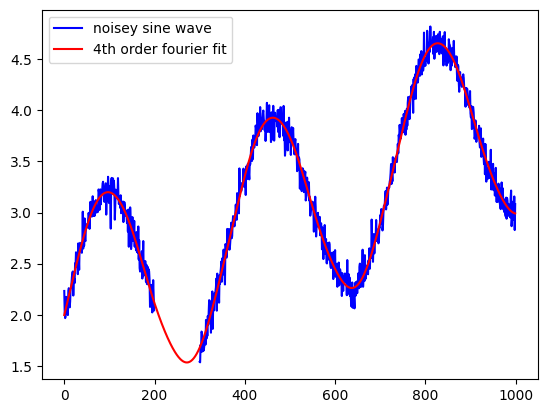

In [13]:
fit = fourier_series(x[:,0,0,0], times, order=4) # just take one of the pixel/bands from the fit
data[data==0] = np.nan # set the masked data back to NaN so they dont shwo on the plot
plt.plot(data[:, 0, 0, 0], color='blue', label='noisey sine wave')
plt.plot(fit, color='red', label='4th order fourier fit')
plt.legend()
plt.show()


We can see that the function works as expected. The missing data is ignored and the fit is still good. This also avoids insidious problems that can occer when NaNs find their way into the data. With normal least squares, a single timestep with NaN values will cause the entire fit to be NaN. This is not the case with this method.